In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import matplotlib as mpl


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,LabelEncoder


import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()


import warnings
warnings.filterwarnings('ignore')

https://www.kaggle.com/crawford/principle-component-analysis-gene-expression/

*Datos usados para clasificar pacientes con acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).*

*Golub et al "Molecular Classification of Cancer: Class Discovery and Class
Prediction by Gene Expression Monitoring"*

*There are two datasets containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent.*

# (1) Analysis steps

1. Remove columns that contain "Call" data
2. Transpose the dataframe so that each row is a patient and each column is a gene
3. Remove gene description header and set the gene accession numbers as the column headers
4. Split into train/test sets
5. Scale values to zero mean and unit varaince

In [2]:
# Load data
testfile = 'genes/data_set_ALL_AML_independent.csv'
trainfile = 'genes/data_set_ALL_AML_train.csv'
labels = 'genes/genes.actual.csv'

X_train = pd.read_csv(trainfile)
X_test = pd.read_csv(testfile)
y = pd.read_csv(labels)

In [3]:
# 1)  Remove "call" columns from training a test
train_keepers = [col for col in X_train.columns if "call" not in col]
test_keepers = [col for col in X_test.columns if "call" not in col]

X_train = X_train[train_keepers]
X_test = X_test[test_keepers]

In [4]:
# 2) Transpose
X_train = X_train.T
X_test = X_test.T
X_train

0     \
Gene Description       AFFX-BioB-5_at (endogenous control)   
Gene Accession Number                       AFFX-BioB-5_at   
1                                                     -214   
2                                                     -139   
3                                                      -76   
4                                                     -135   
5                                                     -106   
6                                                     -138   
7                                                      -72   
8                                                     -413   
9                                                        5   
10                                                     -88   
11                                                    -165   
12                                                     -67   
13                                                     -92   
14                                                    -113   
15                                                    -107   
16                                                    -117   
17                                                    -476   
18                                                     -81   
19                                                     -44   
20                                                      17   
21                                                    -144   
22                                                    -247   
23                                                     -74   
24                                                    -120   
25                                                     -81   
26                                                    -112   
27                                                    -273   
34                                                     -20   
35                                                       7   
36                                                    -213   
37                                                     -25   
38                                                     -72   
28                                                      -4   
29                                                      15   
30                                                    -318   
31                                                     -32   
32                                                    -124   
33                                                    -135   

                                                      1     \
Gene Description       AFFX-BioB-M_at (endogenous control)   
Gene Accession Number                       AFFX-BioB-M_at   
1                                                     -153   
2                                                      -73   
3                                                      -49   
4                                                     -114   
5                                                     -125   
6                                                      -85   
7                                                     -144   
8                                                     -260   
9                                                     -127   
10                                                    -105   
11                                                    -155   
12                                                     -93   
13                                                    -119   
14                                                    -147   
15                                                     -72   
16                                                    -219   
17                                                    -213   
18                                                    -150   
19                                                     -51   
20                                                    -229   
21                                                    -199   
22                     

In [5]:
# 3) Clean up the column names for training data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for training data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_train.head()

Gene Accession Number  AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  \
1                                -214            -153             -58   
2                                -139             -73              -1   
3                                 -76             -49            -307   
4                                -135            -114             265   
5                                -106            -125             -76   

Gene Accession Number  AFFX-BioC-5_at  AFFX-BioC-3_at  AFFX-BioDn-5_at  \
1                                  88            -295             -558   
2                                 283            -264             -400   
3                                 309            -376             -650   
4                                  12            -419             -585   
5                                 168            -230             -284   

Gene Accession Number  AFFX-BioDn-3_at  AFFX-CreX-5_at  AFFX-CreX-3_at  \
1                                  199            -176             252   
2                                 -330            -168             101   
3                                   33            -367             206   
4                                  158            -253              49   
5                                    4            -122              70   

Gene Accession Number  AFFX-BioB-5_st  ...  U48730_at  U58516_at  U73738_at  \
1                                 206  ...        185        511       -125   
2                                  74  ...        169        837        -36   
3                                -215  ...        315       1199         33   
4                                  31  ...        240        835        218   
5                                 252  ...        156        649         57   

Gene Accession Number  X06956_at  X16699_at  X83863_at  Z17240_at  \
1                            389        -37        793        329   
2                            442        -17        782        295   
3                            168         52       1138        777   
4                            174       -110        627        170   
5                            504        -26        250        314   

Gene Accession Number  L49218_f_at  M71243_f_at  Z78285_f_at  
1                               36          191          -37  
2                               11           76          -14  
3                               41          228          -41  
4                              -50          126          -91  
5                               14           56          -25  

[5 rows x 7129 columns]

In [6]:
# 4) Split into train and test 
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subet the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

# (2) Exploratory data analysis

*Realiza un análisis exploratorio de los datos (correlaciones entre sí y con las clases, distribuciones,...). Usa las técnicas y gráficos que te parezcan más representativos.*

En primer lugar conviene notar que nuestro conjunto de datos tiene un total de 7129 características, lo que convierte el problema en un problema de alta dimensión. 

In [7]:
X_train.shape

(38, 7129)

En segundo lugar vamos a observar si existen missing values en el conjunto de datos. 

In [8]:
(X_train.isnull().any()==False).all()

True

Como podemos observar, los datos están completos. A continuación codificamos cada clase de modo que {0: 'ALL', 1: 'AML'}. 

In [9]:
label_enc = LabelEncoder().fit(y_train['cancer'].values)
y_train_enc = label_enc.transform(y_train['cancer'].values)
y_test_enc = label_enc.transform(y_test['cancer'].values)

Ahora vamos a seleccionar aquellas variables cuya correlación con la etiqueta 'cancer' sea superior en valor absoluto al 60%. Se representarán las matrices de correlación de la clase y los atributos seleccionados, así como los histogramas y los diagramas de clases correspondientes, de cada característica agrupado por clase.

In [10]:
# Get correlations of all train data
data = X_train.copy()
data['cancer'] = y_train_enc
corr = data.corr()

# Get columns with correlation greater than 60% in absolute value
corr_cancer = corr['cancer']
cond = abs(corr_cancer.values)>0.6
corr_cancer_filter = corr_cancer[cond]

# Create new data with these conditions
columns = list(corr_cancer_filter.index)[:-1]
data = X_train[columns]
data['cancer'] = y_train_enc
data.head()

Gene Accession Number  AJ000480_at  D10495_at  D14874_at  D38128_at  \
0                              895       -208        163         36   
1                              749        334        176       -952   
2                             1049       -386        133       -762   
3                             1016        366         93       -512   
4                              634        408         75       -897   

Gene Accession Number  D49950_at  HG1879-HT1919_at  HG3494-HT3688_at  \
0                             75               400               223   
1                            129               528              1074   
2                             44               414               148   
3                            218               379               -53   
4                            110               324               353   

Gene Accession Number  HG4321-HT4591_at  J04027_at  L08177_at  ...  \
0                                   -64         96       -110  ...   
1                                   -87        390         18  ...   
2                                   -98        108       -192  ...   
3                                   -90         63        -88  ...   
4                                   174        357         30  ...   

Gene Accession Number  U41767_s_at  X58431_rna2_s_at  X83490_s_at  \
0                             1057               424          -66   
1                              785               368           30   
2                             1147               717           96   
3                             1210               537           42   
4                              594               170           43   

Gene Accession Number  J03801_f_at  M19045_f_at  X14008_rna1_f_at  X16546_at  \
0                              921          382               557        174   
1                             4101         3606              2716        309   
2                             2799         2997              1716        226   
3                             1166         1331              1143        151   
4                             3250         3069              2917        672   

Gene Accession Number  Z30644_at  U21689_at  cancer  
0                           1127      -1660       0  
1                           1378       -973       0  
2                           1324      -3091       0  
3                           1340      -2041       0  
4                            806       -976       0  

[5 rows x 85 columns]

En segundo lugar se muestra la matriz de correlación de las 85 características seleccionadas junto con la variable cancer.

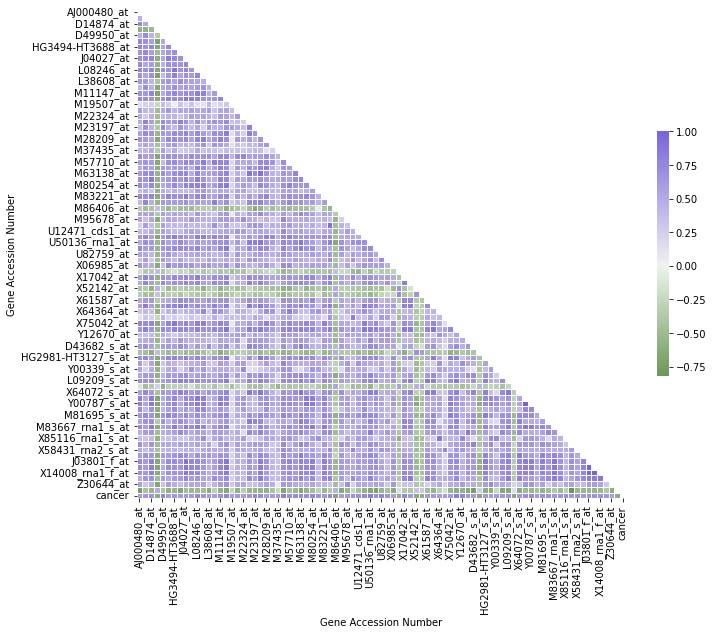

In [11]:
# Compute the correlation matrix
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(120, 630, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Finalmente, se muestran los histogramas de cada característica agrupado por clases así como los diagramas de cajas.

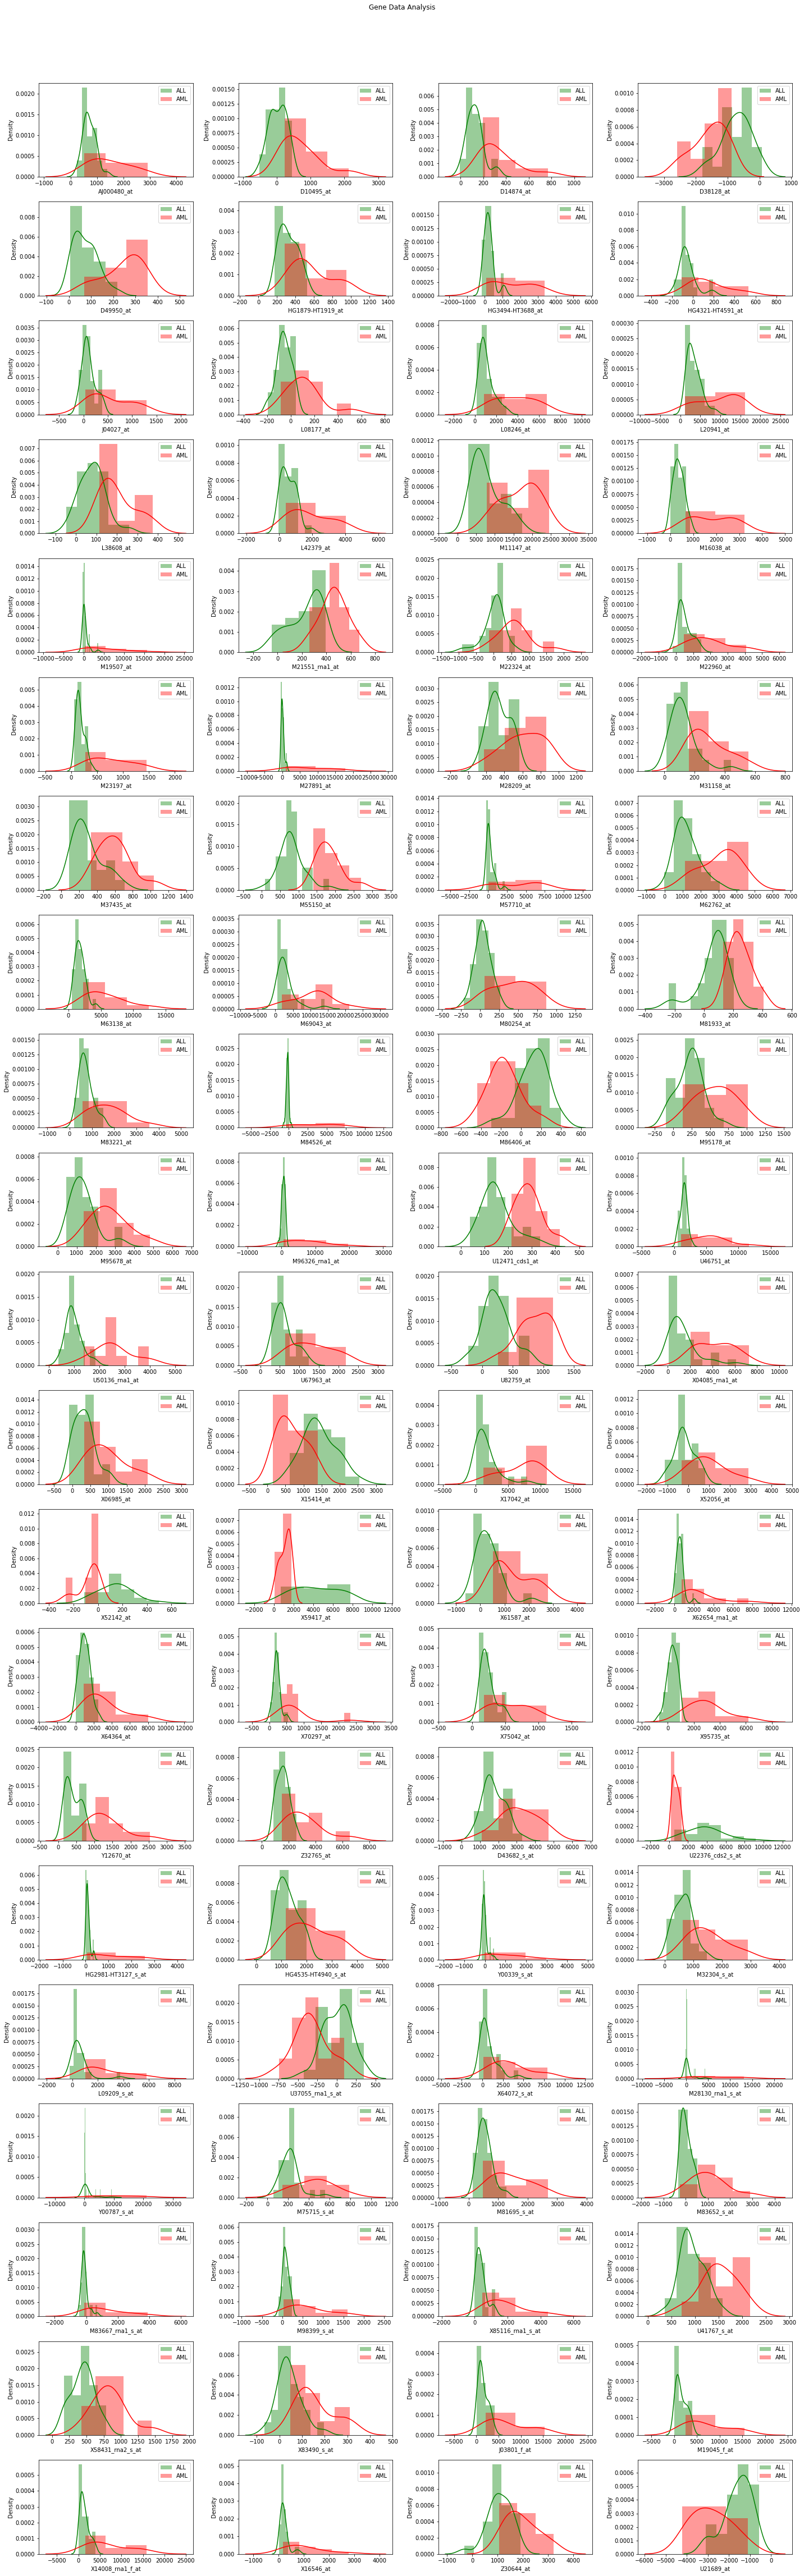

In [12]:
fig = plt.figure(figsize = (20, 65))
j = 0
for i in data.columns[:-1]:
    plt.subplot(21, 4, j+1)
    j += 1
    sns.distplot(data[i][y_train_enc==0], color='g', label = 'ALL')
    sns.distplot(data[i][y_train_enc==1], color='r', label = 'AML')
    plt.legend(loc='best')
fig.suptitle('Gene Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

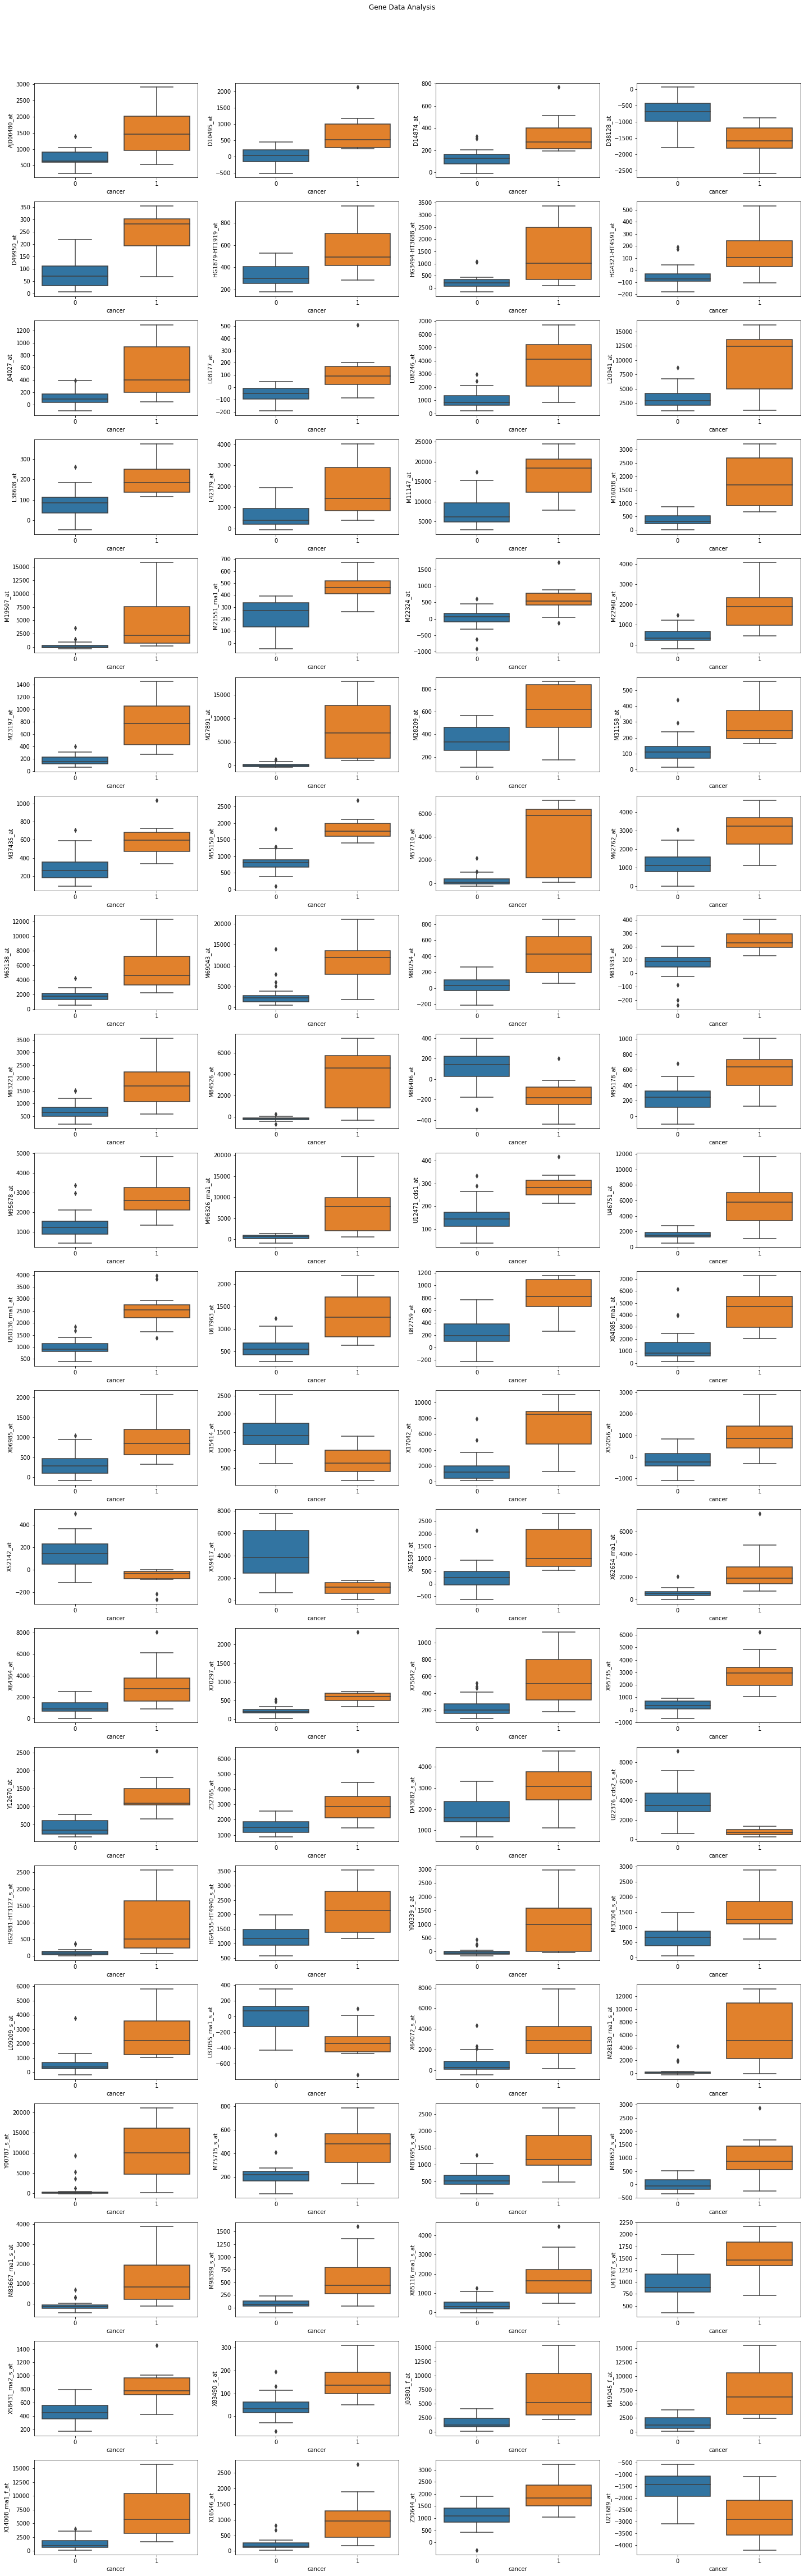

In [13]:
fig = plt.figure(figsize = (20, 65))
j = 0
for i in data.columns[:-1]:
    plt.subplot(21, 4, j+1)
    j += 1
    ax = sns.boxplot(x='cancer', y=i, data=data)
fig.suptitle('Gene Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Observamos que en cada histograma las clases se solapan y no presentan una distribución conocida. También puede observarse la presencia de outliers en algunas características.

# (3) Principle Component Analysis

*The analysis reveals that 21 principle components are needed to account for 80% of the variance. PC 1-3 add up to  about ~33% and the rest is a slow burn where each component after PC8 contributes between 1-2% of the variance up until PC38 which is essentially zero. 1% is a decent amonut of variance and so the number of important PCs is up for interpretation.*

In [14]:
# 5) Scale data 
# (1) YOUR CODE HERE: Use the StandardScaler (separately for train and test sets)
scaler = StandardScaler().fit(X_train)
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)

In [15]:
# 6) PCA Analysis and projection
components = 21
# YOUR CODE HERE: 
# (2) Use PCA with this number of components on train set, with Y the result of the procedure
pca = PCA(n_components=components)
Y = pca.fit(X_train_scl)

# (3) Retrieve the explained variance ratio, and compute its accumulative sum
# save those values in variables var_exp and cum_var_exp
var_exp = Y.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

In [16]:
print(var_exp)
print(cum_var_exp)

[0.14987793 0.11977811 0.06600567 0.0488492  0.04632412 0.037219
 0.03490875 0.03289664 0.02985074 0.0264505  0.02509445 0.02356326
 0.0220301  0.02087031 0.01931271 0.01891243 0.01842475 0.01707946
 0.01684773 0.01637575 0.01533421]
[0.14987793 0.26965604 0.33566172 0.38451091 0.43083503 0.46805403
 0.50296278 0.53585942 0.56571016 0.59216066 0.61725511 0.64081837
 0.66284847 0.68371878 0.70303148 0.72194391 0.74036867 0.75744812
 0.77429585 0.7906716  0.80600581]


Con 21 componentes se consigue un 80% de la varianza explicada.

**Pregunta (1)**: *¿Qué pauta puede observarse en los valores de var_exp? ¿Cuál es la interpretación relativa de esos valores?*

$\texttt{var_exp}$ es el vector que contiene la varianza total explicada por cada componente principal con respecto al conjunto. Vemos que cada vez la varianza explicada por cada componente principal es menor ya que las primeras componentes son las que maximizan la variabilidad de los datos. 

Sea $\Sigma$ la matriz de covarianzas de los datos $X$ que queremos proyectar, la dirección de los componentes principales son los autovectores normalizados de $\Sigma$ correspondientes a los autovalores ordenador de mayor a menor. De manera que los autovalores $\lambda_1>\lambda_2>...$ de $\Sigma$ coinciden con la varianza de las proyecciones. Por tanto, las últimas componentes son aquellas cuyas proyecciones tienen menor varianza y eliminarlas no supone una gran pérdida de información. 

In [17]:
# Plot the explained variance using var_exp and cum_var_exp
x = ["PC%s" %i for i in range(1,components)]
trace1 = go.Bar(
    x=x,
    y=list(var_exp),
    name="Explained Variance")

trace2 = go.Scatter(
    x=x,
    y=cum_var_exp,
    name="Cumulative Variance")

layout = go.Layout(
    title='Explained variance',
    xaxis=dict(title='Principle Components', tickmode='linear'))

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

### Projection of first three components
*The first three components only explain 33% of the variance but we'll go ahead plot the projection to get a visual of it.*

In [18]:
# Project first three components
Y_train_pca = pca.fit_transform(X_train_scl)

traces = []
for name in ['ALL', 'AML']:
    trace = go.Scatter3d(
        x=Y_train_pca[y_train.cancer == name, 0],
        y=Y_train_pca[y_train.cancer == name, 1],
        z=Y_train_pca[y_train.cancer == name, 2],
        mode='markers',
        name=name,
        marker=go.Marker(size=10, line=go.Line(width=1), opacity=1))

    traces.append(trace)

layout = go.Layout(
    xaxis=dict(title='PC1'),
    yaxis=dict(title='PC2'),
    title="Projection of First Three Principle Components"
)

data = traces
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)


/home/maria/main/main/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/home/maria/main/main/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




**Pregunta(2)**: *Modificando la perspectiva de la figura con el ratón, ¿qué observas en cuanto a la separabilidad de las clases? Adjunta una imagen que apoye tus conclusiones.*


En la imagen adjuntada, vemos que la separación de las clases es prácticamente lineal.
![pca_pregunta2](pca.png)

# (4) Linear Discriminant Analysis

*Realizar un análisis similar usando LDA, usando en este caso la información sobre el tipo de cancer de cada paciente. Puedes seguir la guía en https://www.apsl.net/blog/2017/07/18/using-linear-discriminant-analysis-lda-data-explore-step-step/* 

Es importante comentar que estamos trabajando con un problema de clasificación binaria y LDA utiliza una única componente ya que la dimensión del espacio vectorial en el que se proyectan los datos de entrenamiento es siempre menor o igual al número de clases. Por tanto, en la primera componente se explicará el 100% de la varianza del modelo y los datos se proyectarán en un vector normal al límite de decisión entre las dos clases. 

In [19]:
sklearn_lda = LDA(n_components=1)
X_train_lda = sklearn_lda.fit_transform(X_train_scl, y_train_enc)
X_test_lda = sklearn_lda.transform(X_test_scl)

# Mean accuracy on the given training data and labels.
print(
    "Mean accuracy on the given training data and labels: %s\n"
    % str(sklearn_lda.score(X_train_scl, y_train_enc))
)

# Mean accuracy on the given test data and labels.
print(
    "Mean accuracy on the given test data and labels: %s\n"
    % str(sklearn_lda.score(X_test_scl, y_test_enc))
)

print(
    "Explained variance ratio (first component): %s\n"
    % str(sklearn_lda.explained_variance_ratio_)
)

for label in range(0,2):
    mean = np.mean(X_train_lda[y_train_enc==label])
    print('Mean Vector class %s: %s\n' 
          %(label, mean))

for label in range(0,2):
    std = np.std(X_train_lda[y_train_enc==label])
    print('Std Vector class %s: %s\n' 
          %(label, std))

Mean accuracy on the given training data and labels: 0.868421052631579

Mean accuracy on the given test data and labels: 0.6176470588235294

Explained variance ratio (first component): [1.]

Mean Vector class 0: -0.5820367644856832

Mean Vector class 1: 1.4286356946466787

Std Vector class 0: 0.7736049956490063

Std Vector class 1: 1.3430444854571808



A continuación se realiza un histograma de las clases proyectadas de manera unidimensional. Para los datos de entrenamiento transformados vemos la clara separación entre ambas clases. Sin embargo, los datos de prueba se solapan y no se consigue un buen rendimiento, como se vió en la salida anterior del score.

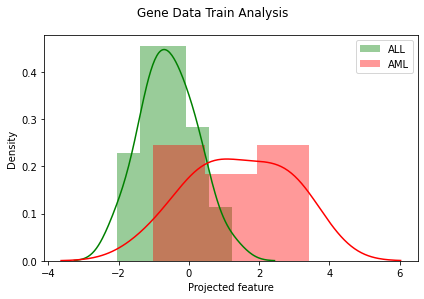

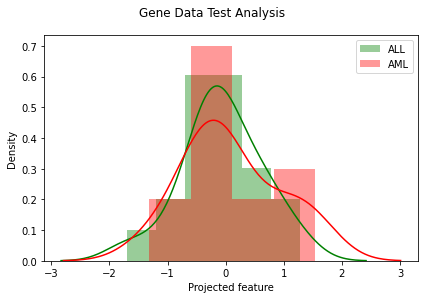

In [20]:
def plot_hist(X, y, title):
    sns.distplot(X[y==0], color='g', label = 'ALL')
    sns.distplot(X[y==1], color='r', label = 'AML')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.xlabel('Projected feature')
    plt.show()
    
plot_hist(X_train_lda, y_train_enc, 'Gene Data Train Analysis')
plot_hist(X_test_lda, y_test_enc, 'Gene Data Test Analysis')

Otro análisis similar se puede realizar proyectando sobre la dirección LD1 los datos transformados de entrenamiento y prueba con LDA. De nuevo se observa la separación entre clases para los datos de entrenamiento proyectados y el solapamiento para los datos de prueba proyectados. En la gráfica, también se ilustran las medias para cada etiqueta.

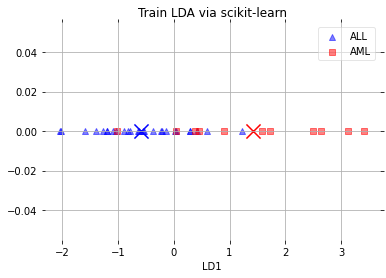

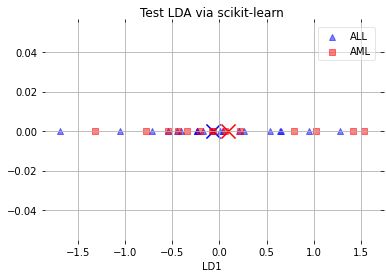

In [21]:
def plot_scikit_lda(X, y, title):
    
    label_dict = {0:'ALL', 1:'AML'}
    
    ax = plt.subplot(111)
    for label, marker, color in zip(
           range(0, 2), ('^', 's'), ('blue', 'red')):
        X_train_lda_i = X[y == label]
        X_train_lda_i_mean = np.array([X_train_lda_i.mean()])
        plt.scatter(x=X_train_lda_i,
                   y=np.zeros(len(X_train_lda_i)),  # flip the figure
                   marker=marker,
                   color=color,
                   alpha=0.5,
                   label=label_dict[label])
        plt.scatter(x= X_train_lda_i_mean,
                   y=0,  # flip the figure
                   marker='x',
                   color=color,
                    s=200)
       

    plt.xlabel('LD1')
    
    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis='both', which='both', bottom='off', top='off',
                   labelbottom='on', left='off', right='off', labelleft='on')

    # remove axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()


plot_scikit_lda(X_train_lda, y_train_enc, title='Train LDA via scikit-learn')
plot_scikit_lda(X_test_lda, y_test_enc, title='Test LDA via scikit-learn')

# (5) Clustering

*Utiliza k-means clustering con los datos originales y con los datos proyectados con PCA y LDA. ¿Qué observas?*

Aunque K means sea un algoritmo no supervisado, este problema es binario, por tanto, vamos a forzar a que el número de clúster del algoritmo sea igual a 2. Así, podremos probar la eficiencia de Kmeans y ver si las predicciones de cada punto coinciden con la etiqueta real.

### K means con los datos originales

En primer lugar, se calcula la suma de los cuadrados de las distancias de los puntos desde sus respectivos centroides del clúster. Este valor, también llamado inertia, indica qué tan internamente coherentes son los clústeres

A continuación se realiza un análisis de siluetas. Este tipo de análisis sirve para estudiar la distancia de separación entre los clúster obtenidos y proporciona una forma de evaluar visualmente el número de clústers. Los coeficientes de silueta tienen un rango de $[-1,1]$ y los valores cercanos a $+1$ indican que la muestra está lejos de los clúster. Por su parte, un valor de 0 indica que la muestra está muy cerca de la frontera de decisión entre dos clúster. Finalmente, los valores negativos indican que esas muestras podrían haber sido asignadas al clúster equivocado.

Suma de cuadrados dentro del grupo:  241408.86104513207


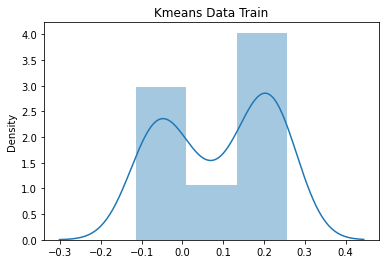

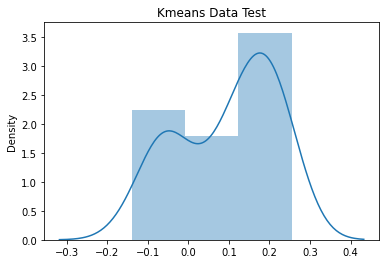

In [22]:
# KMEANS
nclusters=2
kmeans = KMeans(n_clusters=nclusters, random_state=0)
X_train_km = kmeans.fit(X_train_scl)
y_train_km = kmeans.predict(X_train_scl)
y_test_km = kmeans.predict(X_test_scl)
print('Suma de cuadrados dentro del grupo: ', kmeans.inertia_)

# Silhouette analysis for data train
scores = metrics.silhouette_samples(X_train_scl, y_train_km)
sns.distplot(scores)
plt.title('Kmeans Data Train')
plt.show()

# Silhouette analysis for data test
scores = metrics.silhouette_samples(X_test_scl, y_test_km)
sns.distplot(scores)
plt.title('Kmeans Data Test')
plt.show()

Observando los resultados obtenidos vemos que tanto para los datos de prueba y entrenamiento, estos están muy cerca de la frontera de decisión de los dos clúster.

### K means con PCA

Como los datos tiene una gran dimensionalidad, vamos a realizar Kmeans sobre las dos componentes que maximizaban la varianza de los datos de entrenamiento. Para poder interpretar el rendimiento de Kmeans con PCA se mostrará tanto el valor de inertia así como los puntos clasificados por Kmeans respecto a las clases reales.

In [23]:
#PCA
pca = PCA(n_components=2).fit(X_train_scl)
X_train_pca = pca.transform(X_train_scl)
X_test_pca = pca.transform(X_test_scl)

#KMEANS
nclusters=2
kmeans = KMeans(n_clusters=nclusters, random_state=0)
X_train_pca_km = kmeans.fit(X_train_pca)
y_train_pca_km = kmeans.predict(X_train_pca)
y_test_pca_km = kmeans.predict(X_test_pca)
print('Suma de cuadrados dentro del grupo: ', kmeans.inertia_)

Suma de cuadrados dentro del grupo:  44273.60799143746


Vemos como ha disminuido el parámetro inertia de nuestro nuevo clasificador que utiliza los datos proyectados en las dos componentes principales. A continuación, se representan las componentes etiquedas por Kmeans para los datos de entrenamiento y prueba. También se ilustran las matrices de confusión para ambos datos.

Confusion matrix of train data:
 [[19  1]
 [ 8 10]]

Confusion matrix of test data:
 [[13  9]
 [ 7  5]]


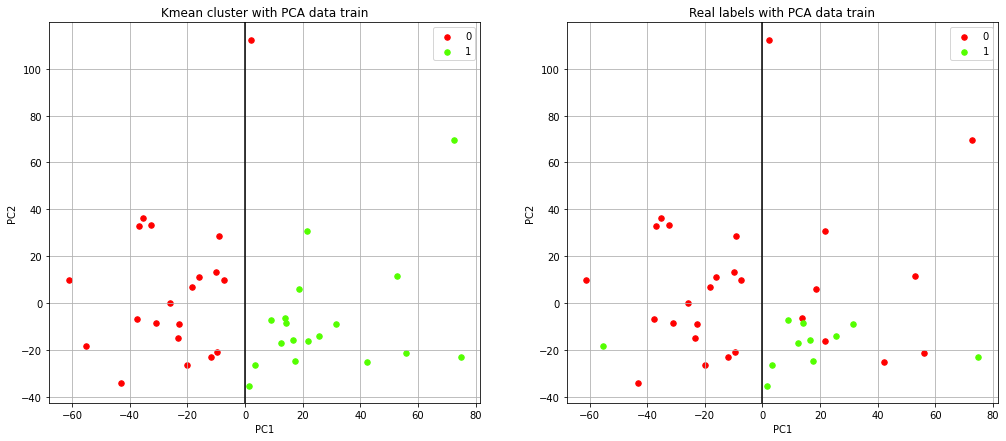

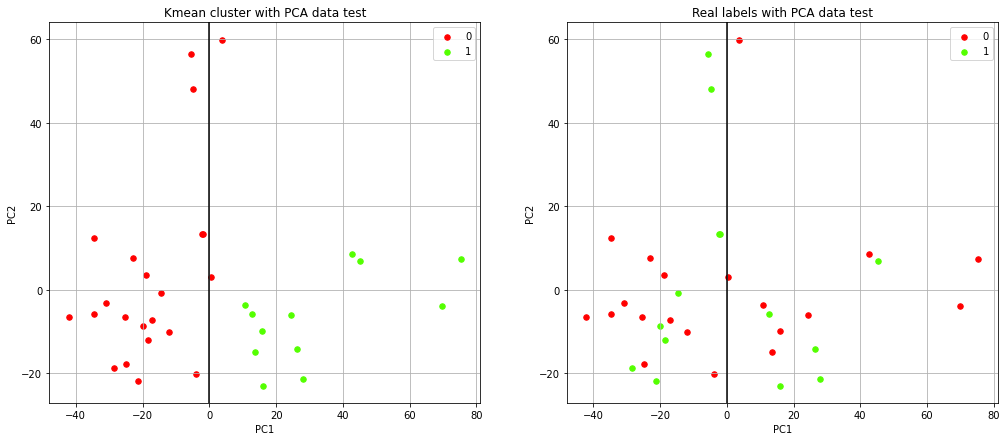

In [24]:
def plotData(df1, groupby1, title1, df_2, groupby2, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17,7))
    # color map
    cmap = mpl.cm.get_cmap('prism')

    for i, cluster in df1.groupby(groupby1):
        cluster.plot(ax = ax1, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s" % i, 
                     s=30)
    ax1.grid()
    ax1.axvline(0, color='black')
    ax1.set_title(title1);
    for i, cluster in df_2.groupby(groupby2):
        cluster.plot(ax = ax2, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s" % i, 
                     s=30)
    ax2.grid()
    ax2.axvline(0, color='black')
    ax2.set_title(title2);

# Train
X_pca = pd.DataFrame(X_train_pca, columns=['PC1','PC2'])
df_plot_train = X_pca.copy()
df_plot_train['ClusterKmeans'] = y_train_pca_km
df_plot_train['Cancer'] = y_train_enc
df_plot_train.head()

# Test
X_pca = pd.DataFrame(X_test_pca, columns=['PC1','PC2'])
df_plot_test = X_pca.copy()
df_plot_test['ClusterKmeans'] = y_test_pca_km
df_plot_test['Cancer'] = y_test_enc
    
plotData(df_plot_train, 'ClusterKmeans','Kmean cluster with PCA data train', df_plot_train, 'Cancer', 'Real labels with PCA data train')
plotData(df_plot_test, 'ClusterKmeans','Kmean cluster with PCA data test', df_plot_test, 'Cancer', 'Real labels with PCA data test')

print('Confusion matrix of train data:\n', metrics.confusion_matrix(df_plot_train['ClusterKmeans'],df_plot_train['Cancer']))
print('\nConfusion matrix of test data:\n', metrics.confusion_matrix(df_plot_test['ClusterKmeans'],df_plot_test['Cancer']))

Tanto en los gráficos como en la matriz de confusión se ve claramente los verdaderos positivos y negativos, así como los errores de clasiciación, siendo mucho mayores para los datos de prueba.

### Kmeans con LDA

De nuevo, se calcula el parámetro de inertia, se represenan los histogramas de los clúster proyectados en la componente de LDA así como la recta con los valores proyectados, y se calculan las matrices de confusión de las predicciones respecto a los valores reales.

Suma de cuadrados dentro del grupo:  21.357177393370186


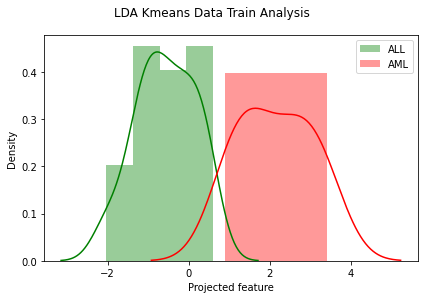

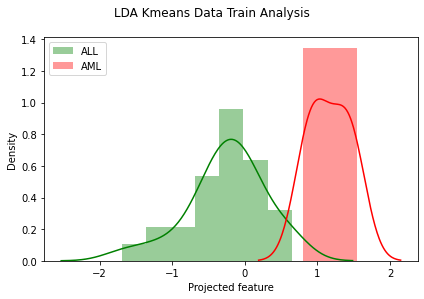

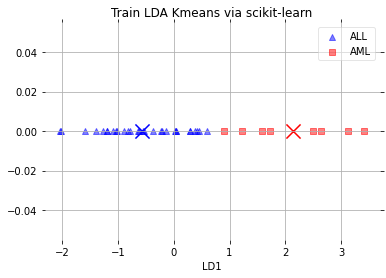

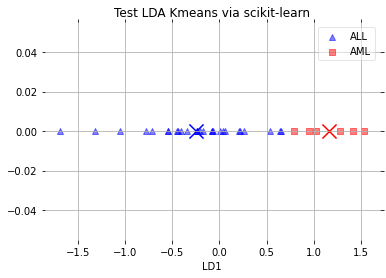

Confusion matrix of train data:
 [[26  4]
 [ 1  7]]

Confusion matrix of test data:
 [[18 10]
 [ 2  4]]


In [25]:
## Kmeans with LDA
nclusters=2
kmeans = KMeans(n_clusters=nclusters, random_state=0)
X_train_lda_km = kmeans.fit(X_train_lda)
y_train_lda_km = kmeans.predict(X_train_lda)
y_test_lda_km = kmeans.predict(X_test_lda)
print('Suma de cuadrados dentro del grupo: ', kmeans.inertia_)

plot_hist(X_train_lda, y_train_lda_km, 'LDA Kmeans Data Train Analysis')
plot_hist(X_test_lda, y_test_lda_km, 'LDA Kmeans Data Train Analysis')
plot_scikit_lda(X_train_lda, y_train_lda_km, title='Train LDA Kmeans via scikit-learn')
plot_scikit_lda(X_test_lda, y_test_lda_km, title='Test LDA Kmeans via scikit-learn')

print('Confusion matrix of train data:\n', metrics.confusion_matrix(y_train_lda_km,y_train_enc))
print('\nConfusion matrix of test data:\n', metrics.confusion_matrix(y_test_lda_km,y_test_enc))

En este caso, el parámetro de inertia es muy bajo, obteniendose un valor de $21.35$. Los histogramas representan claramente la separación entre clases, aunque recordemos que para el caso de los datos de prueba proyectados sobre la componente de LDA las clases continuaban solapadas. Finalmente, en la matriz de confusión se resumen los datos bien y mal clasificados de cada clase, habiéndose reducido considerablemente el número de falsos negativos para los datos de entrenamiento. 